In [900]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

У нас имеется 3 параметра: <br>
`goods_amount` - количество товаров в заказе <br>
`goods_SKU` - количество уникальных позиций в заказе <br>
`store_format` - тип магазина, в котором собирается заказ <br>

В качестве таргета нужно предсказывать время сборки заказа в зависимости от этих 3-х параметров. Для начала рассчитаем его.

### Вычисление таргета

In [901]:
# смотрим как прочитались данные
df = pd.read_csv('out.csv', sep=',')
df

,assembly_id,store_format,goods_amount,goods_SKU,await,assembly,assembled
0,470a14bf-4946-43d3-8393-ee268f0226fc,МД/Мини-Даркстор,16,11,2022-11-25 22:29:52.724424+03,2022-11-25 22:29:59.941036+03,2022-11-25 22:35:09.780991+03
1,0e1dd7cd-22e9-472d-98be-bd44494eed90,МД/Мини-Даркстор,21,6,2022-11-25 22:28:33.460987+03,2022-11-25 22:53:49.705354+03,2022-11-25 23:00:53.648314+03
2,fba48d22-4997-47da-a4fa-3c3f99cb5b0a,МД/Мини-Даркстор,40,21,2022-11-25 22:27:51.784131+03,2022-11-25 22:34:38.225546+03,2022-11-25 23:01:12.551313+03
3,1eed7da3-eaab-4549-b0a7-b76309c76746,МД/Мини-Даркстор,16,15,2022-11-25 22:27:29.864951+03,2022-11-25 22:27:37.525791+03,2022-11-25 22:36:36.600781+03
4,b8c11ea6-ec02-4fb8-a866-a9765027f12d,МД/Мини-Даркстор,31,23,2022-11-25 22:26:08.755234+03,2022-11-25 22:31:38.099024+03,2022-11-25 22:59:00.194444+03
...,...,...,...,...,...,...,...
17165,2bc0faf8-7544-41fc-bbf1-998c7fbe83ab,МД/Супермаркет,14,11,2022-11-25 05:05:32.834498+03,2022-11-25 05:22:38.412341+03,2022-11-25 05:29:23.059119+03
17166,c7527077-74b0-4725-8671-574e0ffe855b,МД/Супермаркет,24,19,2022-11-25 05:04:29.087294+03,2022-11-25 05:11:25.517131+03,2022-11-25 05:38:42.95586+03
17167,ed81acdc-0014-4764-b38f-ef08b0ab22b0,БФ/L+,14,10,2022-11-25 04:52:18.230673+03,2022-11-25 07:01:39.297215+03,2022-11-25 07:19:59.54091+03
17168,47bb1cf2-0806-4bcf-a382-ec8090ee8059,МД/Магазин у дома,26,26,2022-11-25 04:49:15.681203+03,2022-11-25 04:49:38.898344+03,2022-11-25 05:15:24.555777+03


In [902]:
# смотрим есть ли пропуски данных, какие типы данных присвоены
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17170 entries, 0 to 17169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   assembly_id   17170 non-null  object
 1   store_format  17170 non-null  object
 2   goods_amount  17170 non-null  int64 
 3   goods_SKU     17170 non-null  int64 
 4   await         17170 non-null  object
 5   assembly      17170 non-null  object
 6   assembled     17170 non-null  object
dtypes: int64(2), object(5)
memory usage: 939.1+ KB


In [903]:
# проверим, что столбцы не содержат никаких пустых значений 
find_empties = lambda x: sum(x.isnull())
df.apply(find_empties, axis=0)

assembly_id     0
store_format    0
goods_amount    0
goods_SKU       0
await           0
assembly        0
assembled       0
dtype: int64

In [904]:
# приведем столбцы с датой и временем к соотв. типу
df = df.astype({
    'await': 'datetime64',
    'assembly': 'datetime64',
    'assembled': 'datetime64'
})
df.dtypes

assembly_id             object
store_format            object
goods_amount             int64
goods_SKU                int64
await           datetime64[ns]
assembly        datetime64[ns]
assembled       datetime64[ns]
dtype: object

In [905]:
# рассчитаем время сборки заказа
df['assembling_time'] = df['assembled'] - df['assembly']
df.head()

,assembly_id,store_format,goods_amount,goods_SKU,await,assembly,assembled,assembling_time
0,470a14bf-4946-43d3-8393-ee268f0226fc,МД/Мини-Даркстор,16,11,2022-11-25 19:29:52.724424,2022-11-25 19:29:59.941036,2022-11-25 19:35:09.780991,0 days 00:05:09.839955
1,0e1dd7cd-22e9-472d-98be-bd44494eed90,МД/Мини-Даркстор,21,6,2022-11-25 19:28:33.460987,2022-11-25 19:53:49.705354,2022-11-25 20:00:53.648314,0 days 00:07:03.942960
2,fba48d22-4997-47da-a4fa-3c3f99cb5b0a,МД/Мини-Даркстор,40,21,2022-11-25 19:27:51.784131,2022-11-25 19:34:38.225546,2022-11-25 20:01:12.551313,0 days 00:26:34.325767
3,1eed7da3-eaab-4549-b0a7-b76309c76746,МД/Мини-Даркстор,16,15,2022-11-25 19:27:29.864951,2022-11-25 19:27:37.525791,2022-11-25 19:36:36.600781,0 days 00:08:59.074990
4,b8c11ea6-ec02-4fb8-a866-a9765027f12d,МД/Мини-Даркстор,31,23,2022-11-25 19:26:08.755234,2022-11-25 19:31:38.099024,2022-11-25 19:59:00.194444,0 days 00:27:22.095420


In [906]:
# приведем время сборки в адсолютному значению в минутах
convert_to_sec = lambda x: x.total_seconds() / 60
df['assembling_time'] = df['assembling_time'].apply(convert_to_sec)
df

,assembly_id,store_format,goods_amount,goods_SKU,await,assembly,assembled,assembling_time
0,470a14bf-4946-43d3-8393-ee268f0226fc,МД/Мини-Даркстор,16,11,2022-11-25 19:29:52.724424,2022-11-25 19:29:59.941036,2022-11-25 19:35:09.780991,5.163999
1,0e1dd7cd-22e9-472d-98be-bd44494eed90,МД/Мини-Даркстор,21,6,2022-11-25 19:28:33.460987,2022-11-25 19:53:49.705354,2022-11-25 20:00:53.648314,7.065716
2,fba48d22-4997-47da-a4fa-3c3f99cb5b0a,МД/Мини-Даркстор,40,21,2022-11-25 19:27:51.784131,2022-11-25 19:34:38.225546,2022-11-25 20:01:12.551313,26.572096
3,1eed7da3-eaab-4549-b0a7-b76309c76746,МД/Мини-Даркстор,16,15,2022-11-25 19:27:29.864951,2022-11-25 19:27:37.525791,2022-11-25 19:36:36.600781,8.984583
4,b8c11ea6-ec02-4fb8-a866-a9765027f12d,МД/Мини-Даркстор,31,23,2022-11-25 19:26:08.755234,2022-11-25 19:31:38.099024,2022-11-25 19:59:00.194444,27.368257
...,...,...,...,...,...,...,...,...
17165,2bc0faf8-7544-41fc-bbf1-998c7fbe83ab,МД/Супермаркет,14,11,2022-11-25 02:05:32.834498,2022-11-25 02:22:38.412341,2022-11-25 02:29:23.059119,6.744113
17166,c7527077-74b0-4725-8671-574e0ffe855b,МД/Супермаркет,24,19,2022-11-25 02:04:29.087294,2022-11-25 02:11:25.517131,2022-11-25 02:38:42.955860,27.290645
17167,ed81acdc-0014-4764-b38f-ef08b0ab22b0,БФ/L+,14,10,2022-11-25 01:52:18.230673,2022-11-25 04:01:39.297215,2022-11-25 04:19:59.540910,18.337395
17168,47bb1cf2-0806-4bcf-a382-ec8090ee8059,МД/Магазин у дома,26,26,2022-11-25 01:49:15.681203,2022-11-25 01:49:38.898344,2022-11-25 02:15:24.555777,25.760957


In [907]:
# проверим все ли в порядке с типами данных после преобразований
df.dtypes

assembly_id                object
store_format               object
goods_amount                int64
goods_SKU                   int64
await              datetime64[ns]
assembly           datetime64[ns]
assembled          datetime64[ns]
assembling_time           float64
dtype: object

Теперь избавимся от лишних категориальных признаков, которые не будут применяться в обучении модели.

In [908]:
df.head()

,assembly_id,store_format,goods_amount,goods_SKU,await,assembly,assembled,assembling_time
0,470a14bf-4946-43d3-8393-ee268f0226fc,МД/Мини-Даркстор,16,11,2022-11-25 19:29:52.724424,2022-11-25 19:29:59.941036,2022-11-25 19:35:09.780991,5.163999
1,0e1dd7cd-22e9-472d-98be-bd44494eed90,МД/Мини-Даркстор,21,6,2022-11-25 19:28:33.460987,2022-11-25 19:53:49.705354,2022-11-25 20:00:53.648314,7.065716
2,fba48d22-4997-47da-a4fa-3c3f99cb5b0a,МД/Мини-Даркстор,40,21,2022-11-25 19:27:51.784131,2022-11-25 19:34:38.225546,2022-11-25 20:01:12.551313,26.572096
3,1eed7da3-eaab-4549-b0a7-b76309c76746,МД/Мини-Даркстор,16,15,2022-11-25 19:27:29.864951,2022-11-25 19:27:37.525791,2022-11-25 19:36:36.600781,8.984583
4,b8c11ea6-ec02-4fb8-a866-a9765027f12d,МД/Мини-Даркстор,31,23,2022-11-25 19:26:08.755234,2022-11-25 19:31:38.099024,2022-11-25 19:59:00.194444,27.368257


In [909]:
# создадим список необходимых для обучения столбцов
target_cols = df.columns.tolist()
target_cols.insert(4, 'assembling_time')
target_cols.remove('assembly_id')
target_cols = target_cols[:4]
target_cols

['store_format', 'goods_amount', 'goods_SKU', 'assembling_time']

In [910]:
# создадим новый датафрейм с нужными столбцами
df = df[target_cols]
df

,store_format,goods_amount,goods_SKU,assembling_time
0,МД/Мини-Даркстор,16,11,5.163999
1,МД/Мини-Даркстор,21,6,7.065716
2,МД/Мини-Даркстор,40,21,26.572096
3,МД/Мини-Даркстор,16,15,8.984583
4,МД/Мини-Даркстор,31,23,27.368257
...,...,...,...,...
17165,МД/Супермаркет,14,11,6.744113
17166,МД/Супермаркет,24,19,27.290645
17167,БФ/L+,14,10,18.337395
17168,МД/Магазин у дома,26,26,25.760957


### Избавляемся от выбросов

In [911]:
# посмотрим на средние значения времени сборки, количество товаров и уникальных позиций в заказе
df.groupby('store_format').agg('mean').sort_values(by=['assembling_time'], ascending=False)

,goods_amount,goods_SKU,assembling_time
store_format,,,
БФ/M+,36.344000,20.552000,38.359458
БФ/XS,36.695652,24.826087,34.214489
БФ/S+,34.666667,21.071038,33.678115
БФ/S,32.476190,19.206349,31.637828
БФ/L+,35.918605,20.356589,30.452585
БФ/L,36.828571,24.171429,29.728951
ГМ/L,42.888889,24.444444,27.941709
БФ/M,34.392857,19.250000,27.647417
МД/Дискаунтер,26.400000,20.600000,18.647151


In [912]:
# посмотрим на статистики таргета
df.assembling_time.describe()

count    17170.000000
mean        16.948563
std         14.404683
min          0.200885
25%          7.720592
50%         13.372970
75%         22.128953
max        456.395508
Name: assembling_time, dtype: float64

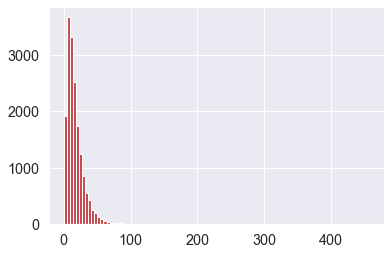

In [913]:
# посмотрим как распределяется время сборки по значениям
for i in df.columns:
    df['assembling_time'].hist(bins=100)

In [914]:
# посмотрим как распределяется время сборки по форматам ТО
func_agg = {
    'assembling_time': ['mean', 'std', 'min', 'max']
}
df.groupby('store_format').agg(func_agg)

assembling_time                                 
                             mean        std       min         max
store_format                                                      
БФ/L                    29.728951  14.507303  9.158526   67.178057
БФ/L+                   30.452585  15.966508  4.123203   89.492698
БФ/M                    27.647417  11.281734  7.826692   57.692215
БФ/M+                   38.359458  20.464878  3.957464  129.016975
БФ/S                    31.637828  15.860268  4.701333   84.821446
БФ/S+                   33.678115  17.964092  2.899790  115.886895
БФ/XS                   34.214489  20.060123  4.122111   73.421160
ГМ/L                    27.941709  14.671982  6.361601   63.520451
МД/Дискаунтер           18.647151  15.191807  5.319695   44.801181
МД/ММ+                  15.523762   9.960617  2.215733   47.141653
МД/Магазин у дома       16.194383  13.728330  0.200885  252.904765
МД/Мини-Даркстор        17.719151  12.119353  0.722100  106.339244
МД/Супермаркет          16.574442  14.355406  0.288508  456.395508
МК/Город МК              6.412225   8.087118  0.379339  141.063138
МК/Деревня МК            5.745475   4.111623  0.703012   16.726836
МК/Магнит-Мастер         1.370220        NaN  1.370220    1.370220
МК/Мегаполис МК          6.079220   6.385927  0.447881   73.440838
МК/Мини МК               7.060018        NaN  7.060018    7.060018

Исходя из значений минимумов, максимумов и «длинного хвоста» на графике видим, что есть выбросы, от которых следует избавиться.

In [915]:
df.shape

(17170, 4)

In [916]:
df.quantile(0.01)

goods_amount       3.000000
goods_SKU          1.000000
assembling_time    1.539508
Name: 0.01, dtype: float64

In [917]:
df.quantile(0.99)

goods_amount       82.310000
goods_SKU          48.000000
assembling_time    64.380596
Name: 0.99, dtype: float64

In [918]:
data = df.copy()
data.drop(df[df.assembling_time < 1.539508].index, axis=0, inplace=True)
data.drop(df[df.assembling_time > 64.380596].index, axis=0, inplace=True)

In [919]:
data.shape

(16826, 4)

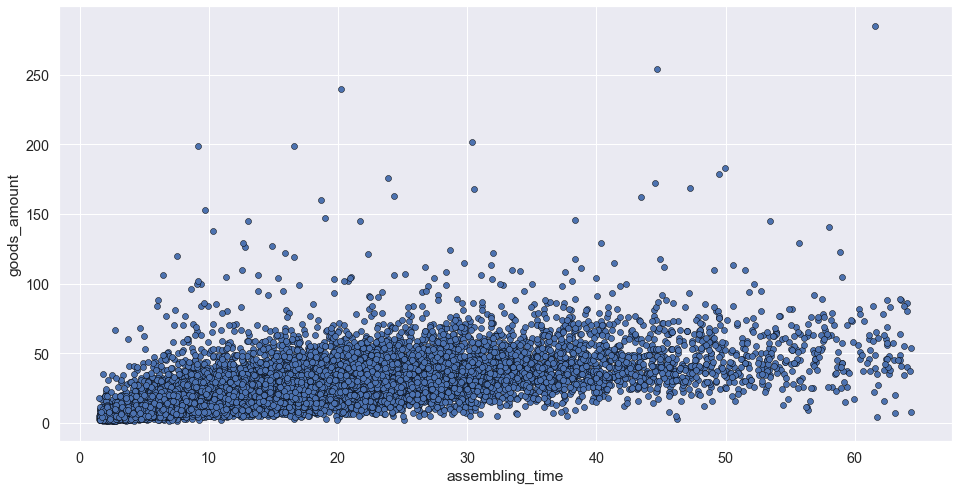

In [920]:
plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.scatterplot(x='assembling_time', y='goods_amount', data=data, edgecolor='black', palette='cubehelix')
plt.show()

In [921]:
# можно поэксперементировать с ограничением количества товаров в сборке
#data.drop(df[df.goods_amount > 100].index, axis=0, inplace=True)

### Категоризуем нечисловые данные

In [922]:
data

,store_format,goods_amount,goods_SKU,assembling_time
0,МД/Мини-Даркстор,16,11,5.163999
1,МД/Мини-Даркстор,21,6,7.065716
2,МД/Мини-Даркстор,40,21,26.572096
3,МД/Мини-Даркстор,16,15,8.984583
4,МД/Мини-Даркстор,31,23,27.368257
...,...,...,...,...
17165,МД/Супермаркет,14,11,6.744113
17166,МД/Супермаркет,24,19,27.290645
17167,БФ/L+,14,10,18.337395
17168,МД/Магазин у дома,26,26,25.760957


In [923]:
# смотрим уникальное количество форматов ТО 
data['store_format'].value_counts()

МД/Супермаркет       7033
МД/Магазин у дома    5081
МД/Мини-Даркстор     2856
МК/Город МК           463
МК/Мегаполис МК       393
БФ/S+                 345
БФ/L+                 251
БФ/M+                 114
БФ/S                   60
БФ/M                   56
МД/ММ+                 51
МК/Деревня МК          45
БФ/L                   34
БФ/XS                  20
ГМ/L                   18
МД/Дискаунтер           5
МК/Мини МК              1
Name: store_format, dtype: int64

Видим, что >80% всех заказов относятся к 5-ти форматам ТО. Их будем использовать для обучения, остальные можно удалить.

In [924]:
# удалим форматы ТО, которые не будут использоваться в обучении модели
target_formats = ['МД/Супермаркет', 'МД/Магазин у дома', 'МД/Мини-Даркстор', 'МК/Город МК', 'МК/Мегаполис МК']
check_target = lambda x: x in target_formats
data = data[data['store_format'].apply(check_target)]
data

,store_format,goods_amount,goods_SKU,assembling_time
0,МД/Мини-Даркстор,16,11,5.163999
1,МД/Мини-Даркстор,21,6,7.065716
2,МД/Мини-Даркстор,40,21,26.572096
3,МД/Мини-Даркстор,16,15,8.984583
4,МД/Мини-Даркстор,31,23,27.368257
...,...,...,...,...
17164,МД/Супермаркет,14,10,19.730990
17165,МД/Супермаркет,14,11,6.744113
17166,МД/Супермаркет,24,19,27.290645
17168,МД/Магазин у дома,26,26,25.760957


In [925]:
# выполним one-hot кодирование категориального признака
data = pd.get_dummies(data, columns=['store_format'])
data

,goods_amount,goods_SKU,assembling_time,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
0,16,11,5.163999,0,1,0,0,0
1,21,6,7.065716,0,1,0,0,0
2,40,21,26.572096,0,1,0,0,0
3,16,15,8.984583,0,1,0,0,0
4,31,23,27.368257,0,1,0,0,0
...,...,...,...,...,...,...,...,...
17164,14,10,19.730990,0,0,1,0,0
17165,14,11,6.744113,0,0,1,0,0
17166,24,19,27.290645,0,0,1,0,0
17168,26,26,25.760957,1,0,0,0,0


Теперь построим корреляционную матрицу признаков.

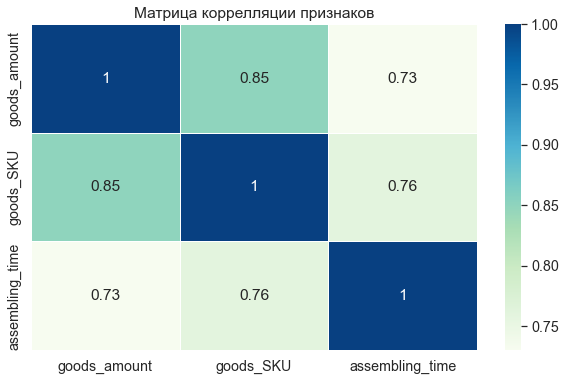

In [926]:
plt.figure(figsize = (10,6))
sns.set(font_scale=1.3)

corr_matrix = data.loc[:, 'goods_amount':'assembling_time'].corr(method='spearman')
# corr_matrix = data.corr(method='pearson')
# corr_matrix = data.corr(method='kendall')
corr_matrix = np.round(corr_matrix, 2)

sns.heatmap(corr_matrix, annot=True, linewidths=.75, cmap='GnBu')

plt.title('Матрица коррелляции признаков')
plt.show()

Видим высокую линейную зависимости между таргетом и остальными признаками.

## Регрессия

In [927]:
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import model_frst
from sklearn.ensemble import RandomForestRegressor

In [928]:
# Разделим датасет на тестовую и тренировочную выборки
X = data.drop('assembling_time', axis=1)
y = data['assembling_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [929]:
X_train

,goods_amount,goods_SKU,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
2754,6,6,0,0,0,1,0
4010,24,15,0,0,1,0,0
6186,18,13,0,0,1,0,0
2334,13,11,0,0,1,0,0
14941,59,29,0,0,1,0,0
...,...,...,...,...,...,...,...
14388,58,37,0,0,1,0,0
5733,9,9,1,0,0,0,0
881,11,8,0,0,1,0,0
17138,30,25,1,0,0,0,0


In [930]:
y_train

2754      6.057183
4010     10.763817
6186     19.551555
2334     15.210460
14941    36.326191
           ...    
14388    36.204417
5733      7.602266
881       9.056394
17138    23.667253
7710      2.640878
Name: assembling_time, Length: 11078, dtype: float64

In [931]:
X_test

,goods_amount,goods_SKU,store_format_МД/Магазин у дома,store_format_МД/Мини-Даркстор,store_format_МД/Супермаркет,store_format_МК/Город МК,store_format_МК/Мегаполис МК
8777,38,25,0,0,1,0,0
171,40,24,0,1,0,0,0
16001,20,11,0,0,1,0,0
9390,8,7,0,1,0,0,0
4361,18,15,1,0,0,0,0
...,...,...,...,...,...,...,...
96,13,12,0,1,0,0,0
15372,48,1,0,0,1,0,0
3301,5,4,1,0,0,0,0
2592,7,6,1,0,0,0,0


In [932]:
y_test

8777     42.455017
171      20.982707
16001    20.273035
9390      8.159521
4361      9.097840
           ...    
96       12.141622
15372    12.592066
3301     10.205643
2592      8.497463
4181     25.108926
Name: assembling_time, Length: 4748, dtype: float64

### Linear

In [933]:
# обучаем модель
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

LinearRegression()

In [934]:
# предсказываем таргет
y_pred_LR = model_LR.predict(X_test)
y_pred_LR

array([24.28191703, 23.28836925, 13.17708836, ...,  6.35677957,
        7.8766193 , 21.47521283])

In [935]:
print('Train: ', model_LR.score(X_train, y_train), 'Test: ', model_LR.score(X_test, y_test)) 

Train:  0.5438225101261984 Test:  0.5245158325866461


In [936]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_LR, y_test)

5.239026209449765

### Random Forest

In [937]:
# обучаем модель
model_Forest = RandomForestRegressor(n_estimators=100, random_state=42)
model_Forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [938]:
# предсказываем таргет
y_pred_Forest = model_Forest.predict(X_test)
y_pred_Forest

array([26.10391448, 17.1596884 , 11.82038308, ...,  6.26282441,
        7.8428445 , 30.47375789])

In [939]:
print('Train: ', model_Forest.score(X_train, y_train), 'Test: ', model_Forest.score(X_test, y_test))

Train:  0.7073528118132064 Test:  0.4273455384931165


In [940]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_Forest, y_test)

5.6687666603367735

### Ridge

In [941]:
# обучаем модель
model_Ridge = linear_model.Ridge()
model_Ridge.fit(X_train, y_train)

Ridge()

In [942]:
# предсказываем таргет
y_pred_Ridge = model_Ridge.predict(X_test)
y_pred_Ridge

array([24.28187738, 23.2880247 , 13.17663533, ...,  6.35611297,
        7.87600898, 21.47507032])

In [943]:
print('Train: ', model_Ridge.score(X_train, y_train), 'Test: ', model_Ridge.score(X_test, y_test))

Train:  0.5438224880313958 Test:  0.524514299148539


In [944]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_Ridge, y_test)

5.238995483261875

### Lasso

In [945]:
# обучаем модель
model_Lasso = linear_model.Lasso()
model_Lasso.fit(X_train, y_train)

Lasso()

In [946]:
# предсказываем таргет
y_pred_Lasso = model_Lasso.predict(X_test)
y_pred_Lasso

array([23.81671022, 23.41900987, 12.68821233, ...,  6.39865561,
        7.9193641 , 21.01706251])

In [947]:
print('Train: ', model_Lasso.score(X_train, y_train), 'Test: ', model_Lasso.score(X_test, y_test))

Train:  0.5380293745082597 Test:  0.5184677623017997


In [948]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_Lasso, y_test)

5.291603771915692

### SVM

In [949]:
# обучаем модель
model_SVM = svm.SVR()
model_SVM.fit(X_train, y_train)

SVR()

In [950]:
# предсказываем таргет
y_pred_SVM = model_SVM.predict(X_test)
y_pred_SVM

array([23.89863878, 23.55032507, 12.00344226, ...,  4.33375023,
        5.71241877, 21.11643261])

In [951]:
print('Train: ', model_SVM.score(X_train, y_train), 'Test: ', model_SVM.score(X_test, y_test))

Train:  0.5331159173749509 Test:  0.5094893033117605


In [952]:
# оцениваем качество обученной модели
mean_absolute_error(y_pred_SVM, y_test)

5.080043772753721

### Экспорт обученной модели

In [959]:
# экспортируем обученную модель в файл
import pickle
filename = 'model_LR.sav'
pickle.dump(model_LR, open(filename, 'wb'))

In [960]:
# проверяем работу обученной модели
model_LR.predict(np.array([[16,4,0,0,0,0,1]]))

/Users/aukorotkov/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([4.73313392])

In [961]:
# проверяем работу обученной модели из файла
model = pickle.load(open(filename, 'rb'))
result = model.predict(np.array([[16,4,0,0,0,0,1]]))
print(result)

[4.73313392]


/Users/aukorotkov/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
